### Stuart-Landau Model

In [2]:
import os
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from tqdm import tqdm

from src.models import simulate

#### Simulation parameters

In [4]:
Nareas = 1
ntrials = 1
fsamp = 1 / 1e-5

time = np.arange(-4, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 10

C = np.array([0]).T


a = -7
I0 = 10
f = 20

In [5]:
time = np.arange(-4, 4, 1 / fsamp)

time_start = 0
time_end = np.inf
Iext = (time > time_start) & (time < time_end)

#### Amplitude only

In [5]:
out = simulate(
    C,
    0,
    f,
    a,
    fsamp,
    0 * beta,
    Npoints,
    I0 * Iext[None,],
    6187,
    "cpu",
    decim,
    "amp",
)

In [6]:
def func(r):
    return a * r - r**3 + I0


root = scipy.optimize.newton(func, 0, fprime=lambda r: a - 3 * r**2)

(-1.0, 1.0)

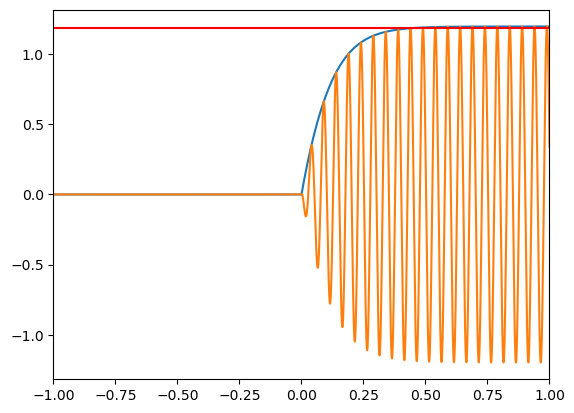

In [7]:
plt.plot(time[::decim], np.abs(out))
plt.plot(time[::decim], np.real(out))

plt.hlines(root, -1, 2, "r")
plt.xlim(-1, 1)

In [8]:
roots = []

for A in np.arange(1, 10000, 1):

    def func(r):
        return -5 * r - r**3 + A

    roots += [scipy.optimize.newton(func, 0, fprime=lambda r: -5 - 3 * r**2)]

/var/folders/y4/188v_l8n7zzcs8c734ytzc3c0000gn/T/ipykernel_7631/2848565260.py:2: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c) + d


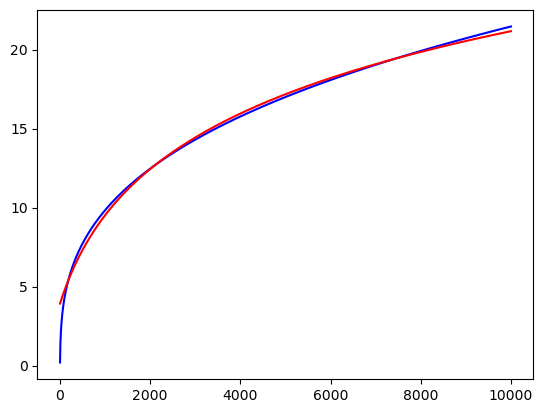

In [9]:
def func(x, a, b, c, d):
    return a * np.log(b * x + c) + d


xdata = np.arange(1, 10000, 1)
ydata = np.stack(roots)
plt.plot(xdata, ydata, "b-", label="data")

popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
popt
plt.plot(xdata, func(xdata, *popt), "r-")

#### Real-valued input

In [10]:
out = simulate(
    C,
    0,
    f,
    a,
    fsamp,
    0 * beta,
    Npoints,
    I0 * Iext[None,],
    6187,
    "cpu",
    decim,
    "both",
)

In [11]:
import sympy as sp

# Define variable
r = sp.symbols("r", real=True, positive=True)

# Parameters
omega = 2 * sp.pi * f
# Fixed point equation
fixed_point_eq = a * r - r**3 + sp.sqrt(I0**2 - omega**2 * r**2)

# Try multiple initial guesses below 0.159 (valid range)
initial_guesses = np.arange(0, 1, 0.001)

# Try solving
for guess in initial_guesses:
    try:
        r_star = sp.nsolve(fixed_point_eq, r, guess)
        theta_star = sp.asin(omega * r_star / I0)
        print(f"Found solution:")
        print(f"r* = {r_star.evalf()}")
        print(f"theta* = {theta_star.evalf()}")
        break
    except Exception as e:
        continue

Found solution:
r* = 0.0794540734686334 - 4.68879428482193e-21*I
theta* = 1.51509952438653 - 1.05709711817337e-18*I


In [12]:
r_float = float(r_star.evalf().as_real_imag()[0])  # First element is the real part

In [13]:
theta_star = np.arcsin(r_float * f * 2 * np.pi / I0)

In [14]:
print(rf"$r^*$ = {r_float}", rf"$\theta^*$ = {theta_star}")

$r^*$ = 0.07945407346863342 $\theta^*$ = 1.5150995243865306


(-1.0, 1.0)

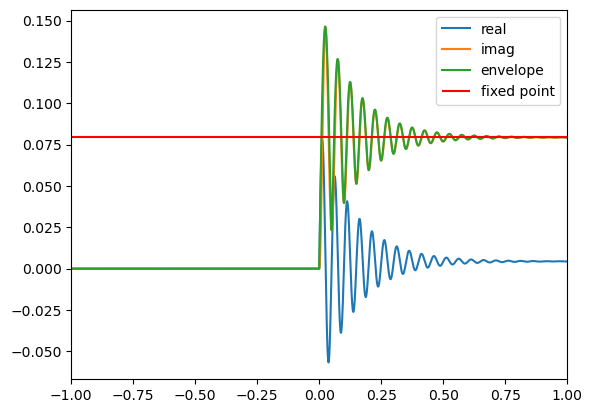

In [15]:
plt.plot(time[::decim], np.real(out))
plt.plot(time[::decim], np.imag(out))
plt.plot(time[::decim], np.abs(out))
plt.hlines(r_float, -1, 4, "r")

plt.legend(["real", "imag", "envelope", "fixed point"])
plt.xlim(-1, 1)

### Stability analysis

In [6]:
a_values = np.linspace(-5, 5, 100)
time = np.arange(0, 1, 1 / fsamp)
time_start = 0
time_end = np.inf
Iext = (time > time_start) & (time < time_end)
I0 = 1e-1
r_star = []
theta_star = []

for a in tqdm( a_values ):
    out = simulate(
        C,
        0,
        f,
        a,
        fsamp,
        0 * beta,
        Npoints,
        I0 * Iext[None,],
        6187,
        "cpu",
        decim,
        "both",
    )
    if a < 0:
        r_star.append( np.abs(out)[-1] )
        theta_star.append( np.sin(np.angle(out)[-1]) ** 2 )
    else:
        r_star.append( np.max(np.abs(out)[-1]) )
        theta_star.append( np.max(np.sin(np.angle(out)[-1]) ** 2) )

100%|█████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


In [7]:
def tau(a: float, I0: float, r: float, x: float) -> float:
    return a - 2 * r * r - I0 / r * np.sqrt(1 - x)


def delta(a: float, I0: float, r: float, x: float) -> float:
    return (2 * I0 * r - a * I0 / r) * np.sqrt(1 - x) + I0**2 / r**2 * x

In [8]:
Tau = []
Delta = []

for i in tqdm( range(a_values.shape[0] - 1) ):

    Tau += [tau(a_values[i], I0, r_star[i], np.sin(theta_star[i])**2)]
    Delta += [delta(a_values[i], I0, r_star[i], np.sin(theta_star[i])**2)]

100%|███████████████████████████████| 99/99 [00:00<00:00, 346318.68it/s]


In [9]:
import seaborn as sns

<Axes: >

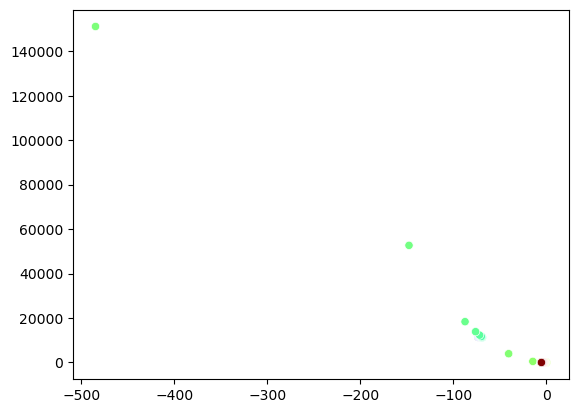

In [11]:
sns.scatterplot(x=Tau, y=Delta, c=a_values[:-1], cmap="jet")

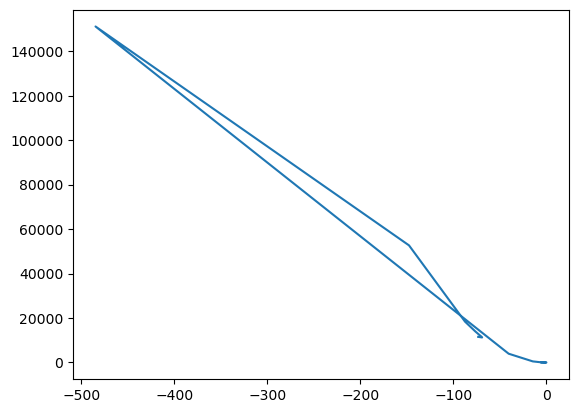

In [13]:
plt.plot(Tau, Delta)

In [95]:
n = 1000

x = np.linspace(0, 1, n)
r = np.linspace(1e-5, 1e-1, n)

a = -3
I0 = 1e-1

J = np.zeros((n, n))

In [96]:
Tau = np.zeros((n, n))
Delta = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        Tau[i, j] = tau(a, I0, r[j], x[i])
        Delta[i, j] = delta(a, I0, r[j], x[i])

D = Tau**2 - 4 * Delta

Text(0, 0.5, '$r$')

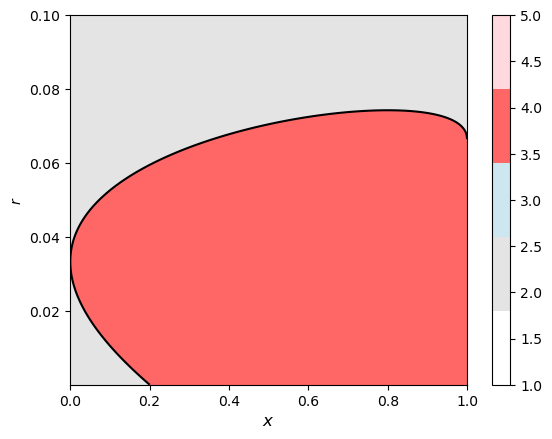

In [89]:
from matplotlib.colors import ListedColormap

region = np.zeros((n, n))

region[(Delta < 0)] = 1  # saddle
region[(Delta > 0) & (D > 0) & (Tau < 0)] = 2  # stable node
region[(Delta > 0) & (D > 0) & (Tau > 0)] = 3  # unstable node
region[(Delta > 0) & (D < 0) & (Tau < 0)] = 4  # stable focus
region[(Delta > 0) & (D < 0) & (Tau > 0)] = 5  # unstable focus


cmap = ListedColormap(["white", "lightgrey", "lightblue", "red", "pink"])
im = plt.imshow(
    region.T,
    origin="lower",
    extent=[x.min(), x.max(), r.min(), r.max()],
    aspect="auto",
    cmap=cmap,
    alpha=0.6,
    vmin=1,
    vmax=5,
)
cbar = plt.colorbar(im)

plt.contour(x, r, D.T, levels=[0], colors="k", linewidths=1.5)
plt.contour(x, r, Delta.T, levels=[0], colors="grey", linewidths=1.5)
plt.contour(x, r, Tau.T, levels=[0], colors="red", linewidths=1.5)
# for t in range(len(out)):
# plt.plot(np.sin( np.angle(out) ) **2, np.abs(out), "b")
# plt.plot(np.sin(theta_star)**2, r_float, "ko", ms=10)
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$r$")

In [4]:
Nareas = 1
ntrials = 1
fsamp = 1 / 1e-5

time = np.arange(-2, 2, 1 / fsamp)
beta = 0
Npoints = len(time)
decim = 100

C = np.array([0]).T

f = 20

In [6]:
n = 100

In [7]:
a_vec = np.linspace(-7, -2, n)
I0_vec = np.linspace(1e-2, 1, n)

In [9]:
time_start = 0
time_end = np.inf
Iext = (time > time_start) & (time < time_end)

In [ ]:
theta_star = np.zeros((n, n))
r_star = np.zeros((n, n))
Tau = np.zeros((n, n))
Delta = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(n):

        out = simulate(
            C,
            0,
            f,
            a_vec[j],
            fsamp,
            0 * beta,
            Npoints,
            I0_vec[i] * Iext[None,],
            6187,
            "cpu",
            decim,
            "both",
        )

        r_star[i, j] = np.abs(out)[-1]
        theta_star[i, j] = np.sin(np.angle(out)[-1]) ** 2
        Tau[i, j] = tau(a_vec[j], I0_vec[i], r_star[i, j], theta_star[i, j])
        Delta[i, j] = delta(a_vec[j], I0_vec[i], r_star[i, j], theta_star[i, j])

 13%|██████████████                                                                                              | 13/100 [17:07<1:54:54, 79.25s/it]

Text(0, 0.5, '$r$')

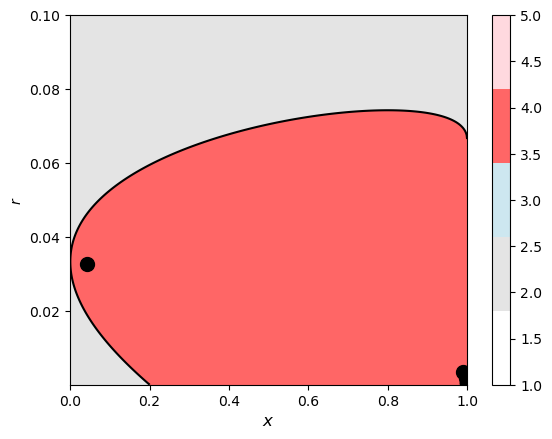

In [97]:
from matplotlib.colors import ListedColormap

region = np.zeros((n, n))

region[(Delta < 0)] = 1  # saddle
region[(Delta > 0) & (D > 0) & (Tau < 0)] = 2  # stable node
region[(Delta > 0) & (D > 0) & (Tau > 0)] = 3  # unstable node
region[(Delta > 0) & (D < 0) & (Tau < 0)] = 4  # stable focus
region[(Delta > 0) & (D < 0) & (Tau > 0)] = 5  # unstable focus


cmap = ListedColormap(["white", "lightgrey", "lightblue", "red", "pink"])
im = plt.imshow(
    region.T,
    origin="lower",
    extent=[x.min(), x.max(), r.min(), r.max()],
    aspect="auto",
    cmap=cmap,
    alpha=0.6,
    vmin=1,
    vmax=5,
)
cbar = plt.colorbar(im)

plt.contour(x, r, D.T, levels=[0], colors="k", linewidths=1.5)
plt.contour(x, r, Delta.T, levels=[0], colors="grey", linewidths=1.5)
plt.contour(x, r, Tau.T, levels=[0], colors="red", linewidths=1.5)
# for t in range(len(out)):
# plt.plot(np.sin( np.angle(out) ) **2, np.abs(out), "b")
plt.plot(theta_star, r_star, "ko", ms=10)
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$r$")